# Lab 5: Binary Classification with Non-Linear Activation (ReLU)

In Lab 1, we built a simple classification model that could only achieve ~50% accuracy on our circle data. The problem: our model could only draw straight-line decision boundaries.

**In this lab**, we'll add **non-linear activation functions (ReLU)** to our model, enabling it to learn curved decision boundaries and achieve much better accuracy!

**Our goal**: Improve accuracy from ~50% to a much higher level by adding non-linearity.

## Setup from Lab 1

First, let's set up everything we need — installing dependencies, importing libraries, and recreating our circle data.

**From Lab 1, we're using:**
- Circle data generation with `make_circles`
- Train/test split
- Accuracy function
- Decision boundary plotting function

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install matplotlib scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cpu


In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.0+cpu


## 1. Recreating the Circle Data

Let's recreate the same circle data from Lab 1. This ensures we're comparing the same problem with different model architectures.

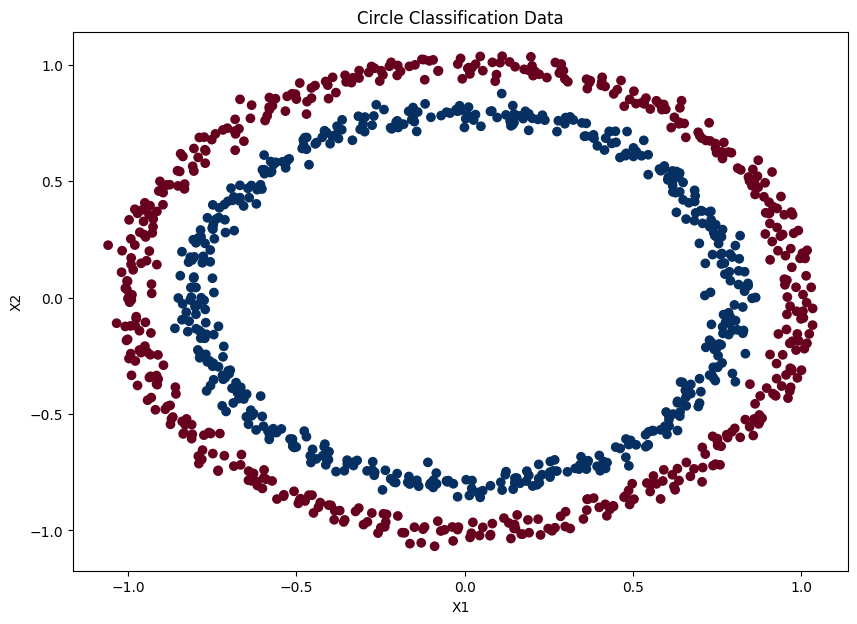

In [3]:
# Make and plot data
n_samples = 1000

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42)

# Visualize
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)
plt.title("Circle Classification Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [4]:
# Convert to tensors and split into train and test sets
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nFirst 5 X_train samples:\n{X_train[:5]}")
print(f"\nFirst 5 y_train labels: {y_train[:5]}")

Training samples: 800
Test samples: 200

First 5 X_train samples:
tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]])

First 5 y_train labels: tensor([1., 0., 0., 0., 1.])


## 2. Helper Functions

Let's define our accuracy function and decision boundary plotting function.

In [5]:
# Accuracy function
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions."""
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [6]:
def plot_decision_boundary(model, X, y):
    """Plots decision boundaries of model predicting on X in comparison to y."""
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    y_pred = torch.round(torch.sigmoid(y_logits))

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

## 3. The Problem: Why Did Our Linear Model Fail?

In Lab 1, we built a neural network with only linear layers:

![Linear Neural Network](https://raw.githubusercontent.com/poridhiEng/lab-asset/c86bc88e676d50722669abf52c9c25213adc5b70/tensorcode/Deep-learning-with-pytorch/Classification/Lab_02/images/network.svg)

The network had:
- **2 input neurons** (X1, X2 coordinates)
- **5 hidden neurons** (to learn patterns)
- **1 output neuron** (class prediction)

But even with this architecture, we only achieved ~50% accuracy. Why?

### The Math Problem

Our model used only linear transformations:

```python
layer_1 = nn.Linear(2, 5)  # Linear transformation
layer_2 = nn.Linear(5, 1)  # Another linear transformation
```

**Stacking linear transformations just gives you another linear transformation!**

```
y = W2 * (W1 * x + b1) + b2
y = W2*W1*x + W2*b1 + b2
y = W'*x + b'  # Still linear!
```

### The Result: A Straight Line Decision Boundary

No matter how many linear layers we stack, the model can only draw **straight lines**:

![Linear Decision Boundary](https://github.com/poridhiEng/lab-asset/blob/main/tensorcode/Deep-learning-with-pytorch/Classification/Lab_02/images/image-1.png?raw=true)

The plots show the decision boundary from Lab 1:
- **Red/Pink region**: Model predicts Class 0
- **Blue region**: Model predicts Class 1
- **The boundary is a straight line** — it cannot curve to separate the circles!

Our circle data needs **curved boundaries**, but a linear model can never create them. That's why we got only ~50% accuracy (random guessing).

## 4. The Solution: Non-Linear Activation Functions

To learn non-linear patterns, we add **activation functions** between layers. The most popular one is **ReLU (Rectified Linear Unit)**:

```
ReLU(x) = max(0, x)
```

- If x > 0: output = x
- If x ≤ 0: output = 0

### Why Does ReLU Help?

ReLU introduces non-linearity by "bending" the output. When combined with multiple layers, the model can approximate **any** function, including curves and circles!

Let's visualize what ReLU does:

In [7]:
# Create a toy tensor to visualize ReLU
A = torch.arange(-10, 10, 1, dtype=torch.float32)
print(f"Input tensor: {A}")

Input tensor: tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])


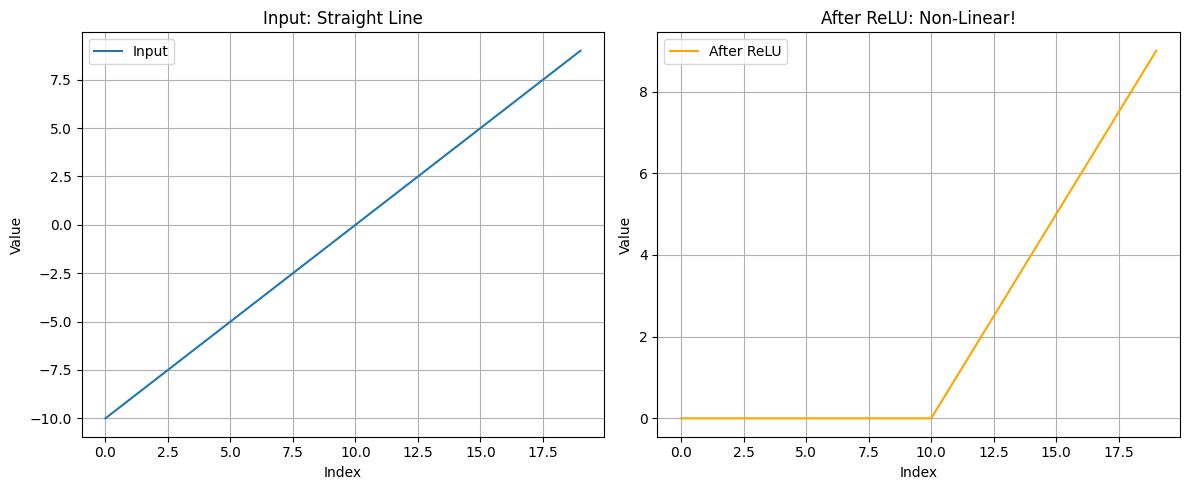

In [8]:
# Visualize the input (straight line)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(A, label="Input")
plt.title("Input: Straight Line")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# Apply ReLU
relu = nn.ReLU()
A_relu = relu(A)

plt.subplot(1, 2, 2)
plt.plot(A_relu, label="After ReLU", color="orange")
plt.title("After ReLU: Non-Linear!")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Notice how ReLU turns all negative values to 0, creating a "bend" in the line. This simple operation allows neural networks to learn complex patterns!

## 5. Building a Model with Non-Linearity

Now let's build a model that uses ReLU activation functions between layers.

![Neural Network with ReLU Activation](https://raw.githubusercontent.com/poridhiEng/lab-asset/c86bc88e676d50722669abf52c9c25213adc5b70/tensorcode/Deep-learning-with-pytorch/Classification/Lab_02/images/relu-network.svg)

The diagram shows our new architecture with ReLU activations:

- **Input Layer (X₁, X₂)**: Takes the 2D coordinates of each point
- **Layer 1 → ReLU**: First linear transformation followed by ReLU activation
- **Layer 2 → ReLU**: Second linear transformation followed by ReLU activation  
- **Layer 3 → Output**: Final linear transformation producing the prediction

**The key difference from Lab 1**: After each hidden layer, we apply ReLU which introduces non-linearity. This allows the network to learn curved decision boundaries instead of just straight lines.

**Model Architecture:**
- Input: 2 features (X1, X2)
- Layer 1: Linear(2 → 10) + ReLU
- Layer 2: Linear(10 → 10) + ReLU
- Layer 3: Linear(10 → 1) (output)

The ReLU between layers allows the model to learn non-linear patterns!

In [9]:
# Build model with non-linear activation function
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()  # <- The key addition!

    def forward(self, x):
        # Intersperse ReLU activation function between layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelV2()
print(model_2)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


### Data Flow Through the Model

Here's how data flows through our model step by step:

**Input [2] → Layer 1 [10] → ReLU → Layer 2 [10] → ReLU → Layer 3 [1] → Output**

1. **Input (X₁, X₂)**: The 2D coordinates enter the network
2. **Layer 1**: Linear transformation from 2 → 10 neurons
3. **ReLU**: Apply `max(0, x)` — introduces non-linearity
4. **Layer 2**: Linear transformation from 10 → 10 neurons
5. **ReLU**: Apply `max(0, x)` again — more non-linearity
6. **Layer 3**: Linear transformation from 10 → 1 neuron
7. **Output**: Raw logits (will be passed through sigmoid for prediction)

The ReLU activations allow each layer to learn different non-linear transformations, combining to create complex decision boundaries.

## 6. Setting Up Loss and Optimizer

We'll use the same loss function and optimizer as Lab 1:
- **Loss**: `BCEWithLogitsLoss` (Binary Cross Entropy with built-in sigmoid)
- **Optimizer**: SGD with learning rate 0.1

In [10]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

print(f"Loss function: {loss_fn}")
print(f"Optimizer: {optimizer}")

Loss function: BCEWithLogitsLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


## 7. Training the Model

Let's train our non-linear model for 1000 epochs. The training loop follows these 5 steps:

1. Zero gradients
2. Forward pass
3. Calculate loss
4. Backward pass (backpropagation)
5. Optimizer step

**Watch the accuracy climb!**

In [11]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    model_2.train()

    # 1. Zero gradients
    optimizer.zero_grad()

    # 2. Forward pass
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # logits -> probs -> labels

    # 3. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 4. Backward pass (backpropagation)
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69390, Accuracy: 50.00% | Test Loss: 0.69309, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69119, Accuracy: 56.00% | Test Loss: 0.69086, Test Accuracy: 59.00%
Epoch: 200 | Loss: 0.68902, Accuracy: 59.25% | Test Loss: 0.68930, Test Accuracy: 60.00%
Epoch: 300 | Loss: 0.68596, Accuracy: 61.38% | Test Loss: 0.68722, Test Accuracy: 59.50%
Epoch: 400 | Loss: 0.68140, Accuracy: 62.12% | Test Loss: 0.68418, Test Accuracy: 58.00%
Epoch: 500 | Loss: 0.67417, Accuracy: 65.12% | Test Loss: 0.67953, Test Accuracy: 61.00%
Epoch: 600 | Loss: 0.66309, Accuracy: 67.88% | Test Loss: 0.67114, Test Accuracy: 64.00%
Epoch: 700 | Loss: 0.64344, Accuracy: 75.25% | Test Loss: 0.65537, Test Accuracy: 65.50%
Epoch: 800 | Loss: 0.60589, Accuracy: 89.00% | Test Loss: 0.62503, Test Accuracy: 81.50%
Epoch: 900 | Loss: 0.54007, Accuracy: 94.00% | Test Loss: 0.56826, Test Accuracy: 89.50%


*Note:* If you notice the `Training` and `Testing` accuracy is not improved significantly, try to **Restart the Kernel** and run the notebook again. This is because the model weights are initialized randomly, and sometimes the random initialization can lead to poor convergence. Additionally, if you run the training cell multiple times without restarting, the model continues training from its current state rather than starting fresh, which can cause unexpected results. Restarting ensures a clean state with fresh random weights.

## 8. Evaluating the Model

Look at that improvement! The accuracy jumped significantly from ~50% (Lab 1)!

Let's make final predictions and calculate the test accuracy.

In [12]:
# Make predictions
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()

# Calculate final accuracy
final_acc = accuracy_fn(y_true=y_test, y_pred=y_preds)
print(f"Final Test Accuracy: {final_acc:.2f}%")

# Show some predictions
print(f"\nFirst 10 predictions: {y_preds[:10].int().tolist()}")
print(f"First 10 actual:      {y_test[:10].int().tolist()}")

Final Test Accuracy: 94.50%

First 10 predictions: [1, 0, 1, 0, 1, 1, 0, 0, 1, 0]
First 10 actual:      [1, 0, 1, 0, 1, 1, 0, 0, 1, 0]


## 9. Visualizing the Decision Boundary

Now let's see the decision boundary our model learned. Unlike Lab 1's straight line, we should see a **curved boundary** that follows the circle pattern!

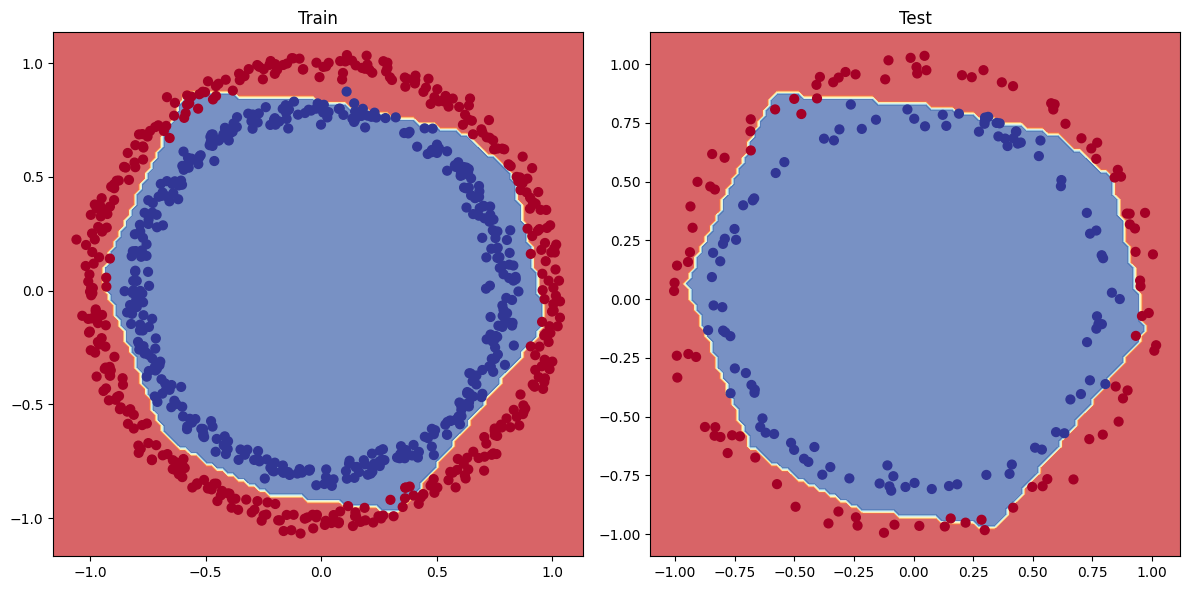

In [13]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)
plt.tight_layout()
plt.show()

**The model learned a circular decision boundary!** This perfectly separates the inner and outer circles.

The ReLU activation functions enabled the model to combine multiple "bent" lines into a curved shape that matches our data.

## 10. Comparing Linear vs Non-Linear Models

Let's create both models and compare their decision boundaries side by side.

In [14]:
# Create a linear model (like Lab 1)
class CircleModelLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        # NO ReLU!

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

# Train linear model
torch.manual_seed(42)
model_linear = CircleModelLinear()
optimizer_linear = torch.optim.SGD(model_linear.parameters(), lr=0.1)

for epoch in range(1000):
    model_linear.train()
    y_logits = model_linear(X_train).squeeze()
    loss = loss_fn(y_logits, y_train)
    optimizer_linear.zero_grad()
    loss.backward()
    optimizer_linear.step()

# Calculate accuracies
model_linear.eval()
with torch.inference_mode():
    linear_preds = torch.round(torch.sigmoid(model_linear(X_test))).squeeze()
    linear_acc = accuracy_fn(y_test, linear_preds)

print(f"Linear Model Accuracy: {linear_acc:.2f}%")
print(f"Non-Linear Model Accuracy: {final_acc:.2f}%")

Linear Model Accuracy: 46.00%
Non-Linear Model Accuracy: 94.50%


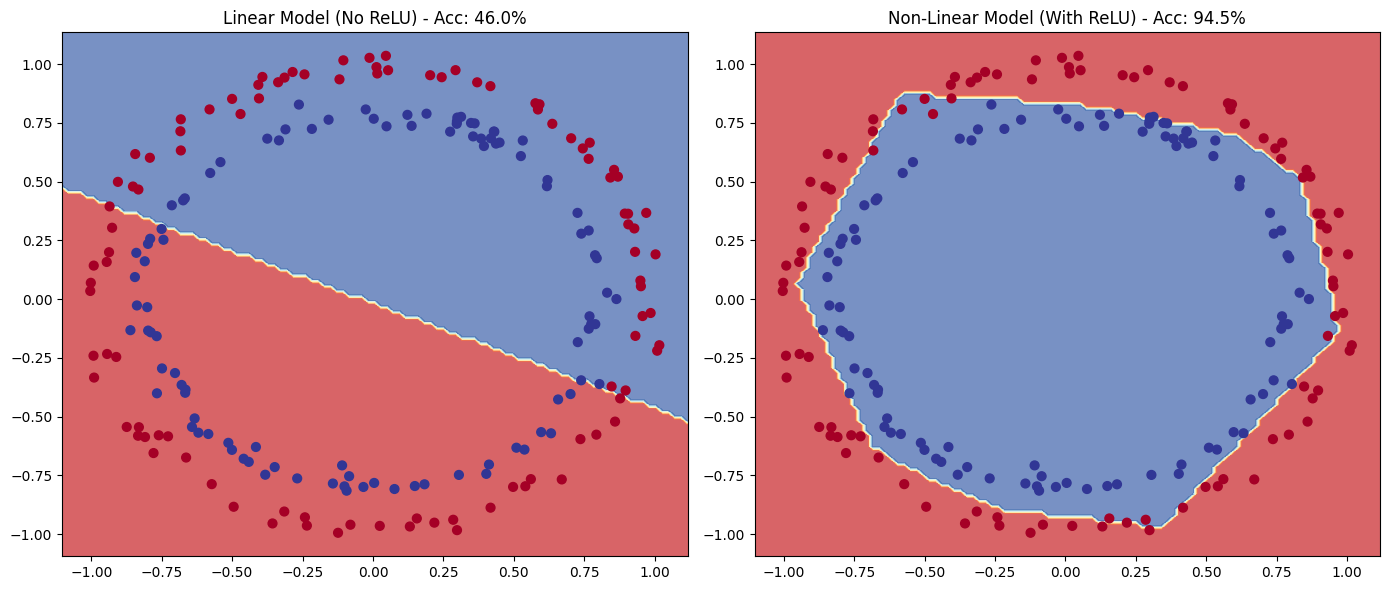

In [15]:
# Compare decision boundaries
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title(f"Linear Model (No ReLU) - Acc: {linear_acc:.1f}%")
plot_decision_boundary(model_linear, X_test, y_test)

plt.subplot(1, 2, 2)
plt.title(f"Non-Linear Model (With ReLU) - Acc: {final_acc:.1f}%")
plot_decision_boundary(model_2, X_test, y_test)

plt.tight_layout()
plt.show()

## 11. Conclusion

Congratulations on completing Lab 2! You've successfully solved the non-linear classification problem that stumped our linear model in Lab 1.

### What We Achieved

In this lab, we transformed a failing model into a working one by understanding a fundamental concept in deep learning: **non-linearity is essential for learning complex patterns**.

**The Problem**: Our circle data couldn't be separated by a straight line, and stacking linear layers only produces more linear transformations.

**The Solution**: By adding ReLU activation functions between layers, we enabled our neural network to learn curved decision boundaries that match the circular pattern in our data.

### Key Takeaways

1. **Non-linear activation functions are essential** for learning complex patterns
2. **ReLU is simple but powerful**: `max(0, x)` enables universal function approximation
3. **Model architecture matters**: Adding more linear layers doesn't help without non-linearity
4. **Visual inspection helps**: Decision boundary plots reveal what the model actually learned

### Next Steps

In **Lab 3**, we'll extend our knowledge to **multiclass classification** — problems with more than 2 classes. We'll use softmax activation and cross-entropy loss to handle multiple categories!